# Text Classification with DistilBERT for Spanish - Machine vs. Human Translations
This notebook is dedicated to building a text classification model that distinguishes between machine-generated and human-generated translations using the DistilBERT model pre-trained for Spanish. The dataset contains two columns: the label (`0` for machine translation and `1` for human translation) and the text. In this workflow, we preprocess the data, tokenize it, and fine-tune a pre-trained model to classify the translations.

## 1. Loading and Inspecting the Dataset
We start by loading the dataset, which is a tab-separated text file. Each row represents a text sample and its corresponding label (`0` for machine translation, `1` for human). Before proceeding with model training, we will inspect the label distribution to ensure there is a reasonable balance in the dataset.

In [1]:
# Load dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv('./data/TRAINING_DATA.txt', sep='\t', header=None)
df.columns = ['label', 'text']

# ⚡ Verify label mapping
print("Label distribution:\n", df['label'].value_counts())


Label distribution:
 label
0    7464
1    7460
Name: count, dtype: int64


Label distribution: We quickly inspect the label distribution to understand class balance. This is crucial as it helps determine whether additional steps, like class weighting or resampling, are needed.  We can see that the dataset is balanced, with ~50% of the texts translated by a machine and ~50% by a human.

## 2. Simplified Preprocessing
For the sake of debugging, we temporarily skip detailed text cleaning. In production, a `clean_text` function could be applied here to remove noise, special characters, and other artifacts. The function was applied on [this file](NLP%20challenge-%20cleaning.ipynb), along with more data exploration

In [2]:
# ⚡ Simplified preprocessing - remove clean_text step temporarily
# from nlp_utils import clean_text
# df['cleaned_text'] = df['text'].apply(clean_text)
df['cleaned_text'] = df['text']  # Bypass cleaning for debugging

## 3. Splitting the Data
The dataset is divided into training, validation, and test sets using an 80-10-10 split. This ensures the model has sufficient data for learning while keeping a reserved portion for evaluation.

In [3]:
# Split data properly
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

## 4. Converting Data to Hugging Face Dataset
Hugging Face's `datasets` library provides a streamlined way to handle text data. We convert the training, validation, and test DataFrames into Hugging Face `Dataset` objects, which allow for efficient batch processing and integration with transformers.

In [5]:
#  ⚡ Convert to HuggingFace Dataset
%pip install datasets
from datasets import Dataset
train_ds = Dataset.from_pandas(train_df[['cleaned_text', 'label']])
val_ds = Dataset.from_pandas(val_df[['cleaned_text', 'label']])
test_ds = Dataset.from_pandas(test_df[['cleaned_text', 'label']])

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_syst

## 5. Tokenizing the Text
To feed the data into a transformer model, we first tokenize the text. The model used here, `distilbert-base-spanish-uncased`, requires properly formatted input, including padding and truncation. We set a maximum length of 256 tokens to balance memory usage and model performance.

In [6]:
# ⚡ Spanish-optimized model
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "dccuchile/distilbert-base-spanish-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# ⚡ Batch tokenization with proper truncation
def tokenize_fn(batch):
    return tokenizer(
        batch['cleaned_text'],
        padding='max_length',
        truncation=True,
        max_length=256  # Increased from 200
    )

train_ds = train_ds.map(tokenize_fn, batched=True)
val_ds = val_ds.map(tokenize_fn, batched=True)
test_ds = test_ds.map(tokenize_fn, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/361 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/486k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/530 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/269M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/distilbert-base-spanish-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/9551 [00:00<?, ? examples/s]

Map:   0%|          | 0/2388 [00:00<?, ? examples/s]

Map:   0%|          | 0/2985 [00:00<?, ? examples/s]

## 6. Preparing Data for PyTorch
We format the tokenized datasets to be compatible with PyTorch, ensuring that the input features (`input_ids`, `attention_mask`) and the labels are correctly structured for the model.

In [7]:
# ⚡ Format datasets for PyTorch
train_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


In [8]:
# After tokenization, verify keys
print(train_ds[0].keys())  # Should only have: input_ids, attention_mask, label

dict_keys(['label', 'input_ids', 'attention_mask'])


## 7. Training the Model
We define custom training arguments to configure the model's learning process, including parameters like learning rate, batch size, and the evaluation strategy. The Trainer class handles the bulk of the training process, including backpropagation and model evaluation.

In [9]:
# ⚡ Enhanced training arguments
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score
import torch

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1': f1_score(labels, preds),
        'f1_macro': f1_score(labels, preds, average='macro')
    }

# 3. Train with default classification head
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=10,
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",  # Focus on F1 for balanced classes
    report_to="none"
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [10]:
import transformers
# ⚡ Improved trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics  # Your existing metrics function
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,F1 Macro
1,0.625100,0.588267,0.684673,0.700119,0.683835
2,0.518200,0.626184,0.669179,0.707191,0.663509
3,0.413100,0.718783,0.652429,0.639130,0.651956
4,0.325500,0.813206,0.650754,0.670616,0.649479
5,0.260800,0.888795,0.638191,0.650202,0.637764
6,0.211300,1.014355,0.632747,0.643061,0.632440
7,0.176200,1.120522,0.631491,0.649123,0.630558
8,0.145700,1.243534,0.629397,0.649227,0.628209
9,0.124400,1.345794,0.627303,0.633745,0.627188
10,0.109900,1.427819,0.624791,0.641026,0.624022


TrainOutput(global_step=2990, training_loss=0.2910397124529682, metrics={'train_runtime': 2139.3664, 'train_samples_per_second': 44.644, 'train_steps_per_second': 1.398, 'total_flos': 6325980622817280.0, 'train_loss': 0.2910397124529682, 'epoch': 10.0})

## 8. Model Evaluation on Test Set
Once the training is complete, we evaluate the model on the test set. We are particularly interested in accuracy and F1 score to ensure the model performs well on both metrics.

In [11]:
# Final evaluation
test_results = trainer.evaluate(test_ds)
print("\nTest set performance:")
print(f"Accuracy: {test_results['eval_accuracy']:.4f}")
print(f"F1 Score: {test_results['eval_f1']:.4f}")
print(f"Macro F1: {test_results['eval_f1_macro']:.4f}")


Test set performance:
Accuracy: 0.6600
F1 Score: 0.7021
Macro F1: 0.6530


## 9. Error Analysis: Confusion Matrix
To better understand the model's behavior, we generate a confusion matrix. This visualizes where the model makes classification errors, such as misclassifying human translations as machine translations, and vice versa.

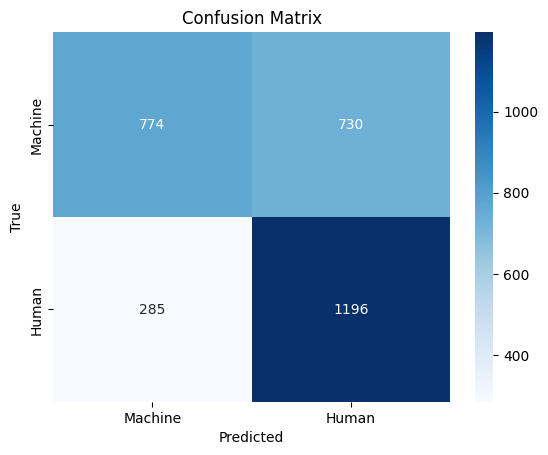

In [12]:
# ⚡ Error analysis
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

preds = trainer.predict(test_ds)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Machine', 'Human'],
            yticklabels=['Machine', 'Human'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## 10. Saving the Model and Predictions
Finally, we save the trained model and tokenizer to Google Drive for future use. We also save the predicted labels for further analysis.

In [13]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define Google Drive folder path
drive_folder_path = '/content/drive/My Drive/Colab Notebooks/animals10 CNN Project/distilbert3'

# Save the model
model.save_pretrained(drive_folder_path)
tokenizer.save_pretrained(drive_folder_path)
trainer.save_model(drive_folder_path)

Mounted at /content/drive


and we also save it to the output directory for further use.

In [14]:
pred_label = pd.DataFrame({'label': y_pred})
pred_label.to_csv('./data/predictions distilbert2 60 percent3.csv', index=False)
pred_label.to_csv(drive_folder_path + '/predictions distilbert2 60 percent3.csv', index=False)

This completes the workflow for building a Spanish text classifier to distinguish between machine and human translations using DistilBERT. With the final evaluation and saved model, the project is ready for deployment or further refinement.